In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [3]:
def crop(img,mask):
    blur = cv2.GaussianBlur(img,(5,5),0)
    _,breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    return breast_mask

def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit = clip)
    cl = clahe.apply(np.array(img*255,dtype = np.uint8))
    return cl

images = []
labels = []
class_label = 0
def load_images_from_folder(folder,class_label):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img,(200,200))
            mask = np.zeros(img.shape , dtype = np.uint8)
            img = crop(img,mask)
            img = cv2.normalize(img,mask,0,255,cv2.NORM_MINMAX)
            img = clahe(img,2.0)            
            img = img.reshape(200,200,1).flatten()
            images.append(img)
            labels.append(class_label)
    class_label = class_label+1
    return class_label
    
class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Normal cases",class_label)
class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Bengin cases",class_label)
class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Malignant cases",class_label)

In [39]:
images = np.array(images)
labels = np.array(labels)

In [40]:
print(images.shape)
print(labels.shape)

(1097, 200, 200)
(1097,)


In [41]:
np.unique(labels)

array([0, 1, 2])

In [42]:
np.unique(images)

array([2, 3, 4, 5], dtype=uint8)

In [43]:
pd.Series(labels).value_counts()

2    561
0    416
1    120
dtype: int64

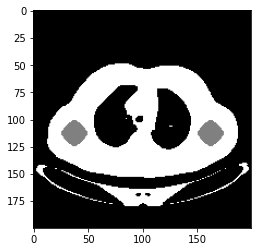

In [44]:
plt.imshow(images[0],cmap='gray')

In [4]:
data = np.asarray(images)
print(data.shape)
data = preprocessing.StandardScaler().fit(data).transform(data.astype(int))
print(data.shape)
labels = np.asarray(labels)
print(labels.shape)

(1097, 40000)
(1097, 40000)
(1097,)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,random_state=1)

print (X_train.shape)
print ("test data shape:")
print (X_test.shape)
print ("train label shape:")
print (y_train.shape)
print ("test label shape:")
print (y_test.shape)

(877, 40000)
test data shape:
(220, 40000)
train label shape:
(877,)
test label shape:
(220,)


In [6]:
print(X_train.max(),X_train.min())
print(X_test.max(),X_test.min())
X_train = X_train/255
X_test = X_test/255
print(X_train.max(),X_train.min())
print(X_test.max(),X_test.min())

33.10589071449375 -13.484559070779262
33.105890714493725 -13.484559070779262
0.12982702240977942 -0.0528806238069775
0.1298270224097793 -0.0528806238069775


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

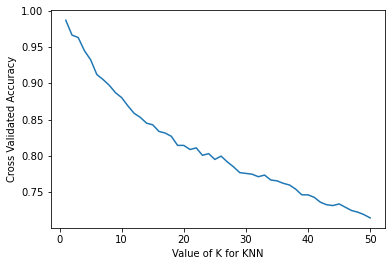

In [8]:
k_range = range(1,51)
k_scores = []

for k in k_range:
    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    
plt.plot(k_range, k_scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross Validated Accuracy")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (50,) and (100,)

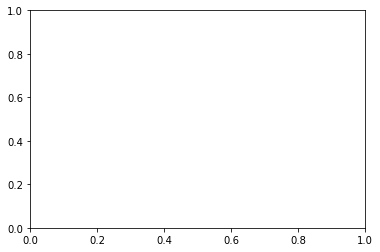

In [9]:
k_range =range(1,51)
k_score = []

for k in k_range:
    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=k))
    loss = abs(cross_val_score(knn,X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
    
plt.plot(k_range,k_scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross Validated MSE")
plt.show()


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        88
           1       1.00      0.96      0.98        24
           2       1.00      1.00      1.00       108

    accuracy                           1.00       220
   macro avg       1.00      0.99      0.99       220
weighted avg       1.00      1.00      1.00       220

KNN Accuracy 0.995


<AxesSubplot:>

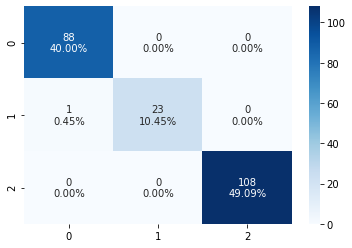

In [10]:
from sklearn.metrics import classification_report
import seaborn as sns

knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=1))
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)
print(classification_report(y_test,predictions))
cm = confusion_matrix(y_test,predictions)
#sns.heatmap(cm,annot=True,fmt='')
print("KNN Accuracy %.3f" % accuracy_score(y_test,predictions))

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

Labels = [f"{v2}\n{v3}" for v2,v3 in zip(group_counts,group_percentages)]

Labels = np.asarray(Labels).reshape(3,3)

sns.heatmap(cm,annot=Labels,fmt='',cmap='Blues')

In [11]:
report = classification_report(y_test,predictions,output_dict=True)
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']
macro_f1 = report['macro avg']['f1-score']
accuracy = report['accuracy']
dict_ = {'Precision':macro_precision,'Recall':macro_recall,'F1-Score':macro_f1,'Accuracy':accuracy}
dff = pd.DataFrame.from_records([dict_])
data4 = dff.transpose()
data4.rename(columns = {0:'KNN'}, inplace = True)
data4

,KNN
Precision,0.996255
Recall,0.986111
F1-Score,0.991025
Accuracy,0.995455


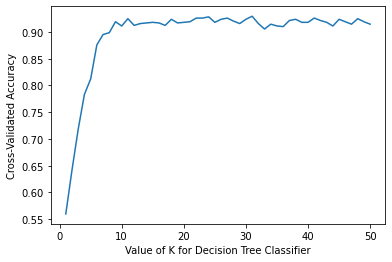

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
k_range = range(1, 51)
k_scores = []
for k in k_range:
    knn = DecisionTreeClassifier(criterion="entropy",max_depth = k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for Decision Tree Classifier')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

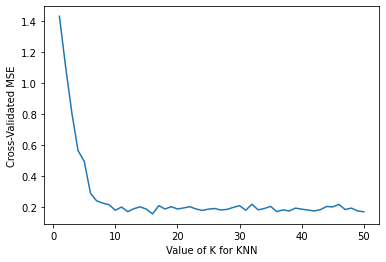

In [13]:
k_range = range(1, 51)
k_scores = []
for k in k_range:
    #print(k)
    knn = DecisionTreeClassifier(criterion="entropy",max_depth = k)
    loss = abs(cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.92      0.95        88
           1       0.92      0.92      0.92        24
           2       0.95      1.00      0.97       108

    accuracy                           0.96       220
   macro avg       0.95      0.95      0.95       220
weighted avg       0.96      0.96      0.96       220

Decision Tree Accuracy: 0.959


<AxesSubplot:>

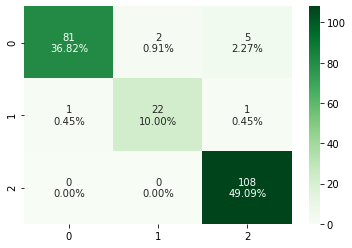

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
dtc = OneVsRestClassifier(DecisionTreeClassifier(criterion="entropy",max_depth = 50))
dtc.fit(X_train,y_train)
predictionss = dtc.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix # metrics error
cm = confusion_matrix(y_test, predictionss)
import seaborn as sns
print(classification_report(y_test, predictionss))
print('Decision Tree Accuracy: %.3f' % accuracy_score(y_test,predictionss))
#group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
Labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
Labels = np.asarray(Labels).reshape(3,3)
sns.heatmap(cm, annot=Labels, fmt='', cmap='Greens')

In [16]:
report = classification_report(y_test, predictionss,output_dict=True)
macro_precision =  report['macro avg']['precision'] 
macro_recall = report['macro avg']['recall']    
macro_f1 = report['macro avg']['f1-score']
accuracy = report['accuracy']
listend = []
listend.append(macro_precision)
listend.append(macro_recall)
listend.append(macro_f1)
listend.append(accuracy)
data4['Decision Tree Classifier'] = listend
data4

,KNN,Decision Tree Classifier
Precision,0.996255,0.950613
Recall,0.986111,0.945707
F1-Score,0.991025,0.947527
Accuracy,0.995455,0.959091


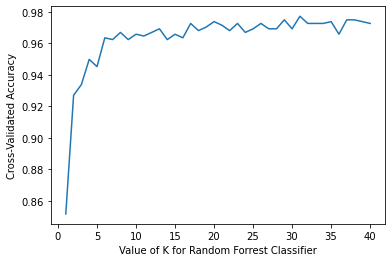

In [18]:
from sklearn.ensemble import RandomForestClassifier

k_range = range(1, 41)
k_scores = []
for k in k_range:
    #print(k)
    knn = OneVsRestClassifier(RandomForestClassifier(n_estimators = k))
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for Random Forrest Classifier')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

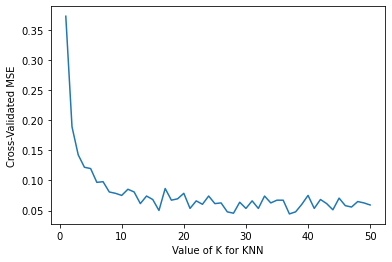

In [20]:
k_range = range(1, 51)
k_scores = []
for k in k_range:
    #print(k)
    knn = OneVsRestClassifier(RandomForestClassifier(n_estimators = k))
    loss = abs(cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        88
           1       1.00      0.92      0.96        24
           2       1.00      1.00      1.00       108

    accuracy                           0.99       220
   macro avg       0.99      0.97      0.98       220
weighted avg       0.99      0.99      0.99       220

Random Tree Accuracy: 0.991


<AxesSubplot:>

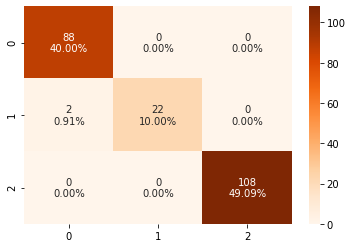

In [22]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators = 50))
rfc.fit(X_train,y_train)
predictionsss = rfc.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix # metrics error
#print(confusion_matrix(Y_test, predictionsss))
print(classification_report(y_test, predictionsss))
print('Random Tree Accuracy: %.3f' % accuracy_score(y_test,predictionsss))
cm = confusion_matrix(y_test, predictionsss)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
Labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
Labels = np.asarray(Labels).reshape(3,3)
sns.heatmap(cm, annot=Labels, fmt='', cmap='Oranges')

In [23]:
report = classification_report(y_test, predictionsss,output_dict=True)
macro_precision =  report['macro avg']['precision'] 
macro_recall = report['macro avg']['recall']    
macro_f1 = report['macro avg']['f1-score']
accuracy = report['accuracy']
listend = []
listend.append(macro_precision)
listend.append(macro_recall)
listend.append(macro_f1)
listend.append(accuracy)
data4['Random Forrest Classifier'] = listend
data4

,KNN,Decision Tree Classifier,Random Forrest Classifier
Precision,0.996255,0.950613,0.992593
Recall,0.986111,0.945707,0.972222
F1-Score,0.991025,0.947527,0.981762
Accuracy,0.995455,0.959091,0.990909


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        88
           1       1.00      0.62      0.77        24
           2       0.99      1.00      1.00       108

    accuracy                           0.96       220
   macro avg       0.97      0.88      0.91       220
weighted avg       0.96      0.96      0.96       220

SVC Accuracy: 0.959


<AxesSubplot:>

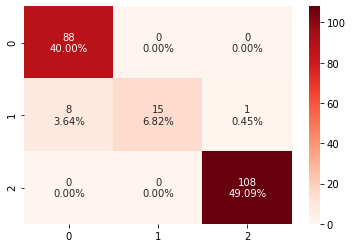

In [24]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

regr = OneVsRestClassifier(SVC(kernel='linear'))
regr.fit(X_train,y_train)
predictionn = regr.predict(X_test)

print(classification_report(y_test,predictionn))
print("SVC Accuracy: %.3f" %accuracy_score(y_test,predictionn))
cm = confusion_matrix(y_test,predictionn)

group_count = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

Labels = [f"{v2}\n{v3}" for v2,v3 in zip(group_count,group_percentages)]
Labels = np.asarray(Labels).reshape(3,3)

sns.heatmap(cm, annot=Labels, fmt='', cmap="Reds")

In [100]:
images = []
labels = []
class_label = 0
def load_images_from_folder(folder,class_label):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img,(200,200))
            mask = np.zeros(img.shape , dtype = np.uint8)
            img = crop(img,mask)
            img = cv2.normalize(img,mask,0,255,cv2.NORM_MINMAX)
            img = clahe(img,2.0)            
            img = img.reshape(200,200,1)
            images.append(img)
            labels.append(class_label)
    class_label = class_label+1
    return class_label
    
class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Normal cases",class_label)
class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Bengin cases",class_label)
class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Malignant cases",class_label)

# images = []
# labels = []
# class_label = 0
# def load_images_from_folder(folder,class_label):
#     for filename in os.listdir(folder):
#         img = cv2.imread(os.path.join(filename,folder))
#         if img is not None:
#             img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#             img = cv2.resize(img,(200,200))
#             mask = np.zeros(img.shape, dtype=np.uint8)
#             img = crop(img,mask)
#             img = cv2.normalize(img,mask,0,255, cv2.NORM_MINMAX)
#             img = clahe(img, 2.0)
#             img = img.reshape(200,200,1).flatten()
#             images = images.append(img)
#             labels.append(class_label)
#     class_label = class_label+1
#     return class_label
        
# class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Normal cases",class_label)
# class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Bengin cases",class_label)
# class_label = load_images_from_folder(r"D:\Research\_KLU\Implemention\Module 2\1 The IQ-OTHNCCD lung cancer dataset\Malignant cases",class_label)

In [101]:
data = np.asarray(images)
label = np.asarray(labels)
data.shape, label.shape

((1097, 200, 200, 1), (1097,))

In [102]:
X_train,X_test,y_train,y_test=train_test_split(data,label,test_size=0.2,random_state=1)
X_train = X_train / 255
X_test = X_test / 255
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
classes = y_test.shape[1]
print ("train data shape:")
print (X_train.shape)
print ("test data shape:")
print (X_test.shape)
print ("train label shape:")
print (y_train.shape)
print ("test label shape:")
print (y_test.shape)

train data shape:
(877, 200, 200, 1)
test data shape:
(220, 200, 200, 1)
train label shape:
(877, 3)
test label shape:
(220, 3)


In [107]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import h5py
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split

In [104]:
# # Convert 1-dimensional class arrays to 10-dimensional class matrices
# Y_train = np_utils.to_categorical(y_train, 10)
# Y_test = np_utils.to_categorical(y_test, 10)

In [108]:
def larger_model(classes):
    model = Sequential()
    model.add(Conv2D(32,(3,3), padding="same", input_shape=(200,200,1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [112]:
#from sklearn.model_selection import train_test_split
#Built the model
model2 = larger_model(y_test.shape[1])
#Fit the model
hist = model2.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=120, batch_size=300)
model2.summary()

Epoch 1/10
28/28 [==============================] - 129s 4s/step - loss: 1.0025 - accuracy: 0.4595 - val_loss: 0.9933 - val_accuracy: 0.4909
Epoch 2/10
28/28 [==============================] - 174s 6s/step - loss: 0.9741 - accuracy: 0.4983 - val_loss: 0.9795 - val_accuracy: 0.4909
Epoch 3/10
28/28 [==============================] - 154s 6s/step - loss: 0.9700 - accuracy: 0.4937 - val_loss: 0.9598 - val_accuracy: 0.4909
Epoch 4/10
28/28 [==============================] - 155s 6s/step - loss: 0.9727 - accuracy: 0.5086 - val_loss: 0.9626 - val_accuracy: 0.4909
Epoch 5/10
28/28 [==============================] - 143s 5s/step - loss: 0.9590 - accuracy: 0.5086 - val_loss: 0.9627 - val_accuracy: 0.4909
Epoch 6/10
28/28 [==============================] - 112s 4s/step - loss: 0.9678 - accuracy: 0.5143 - val_loss: 0.9614 - val_accuracy: 0.4909
Epoch 7/10
28/28 [==============================] - 104s 4s/step - loss: 0.9688 - accuracy: 0.5143 - val_loss: 0.9618 - val_accuracy: 0.4909
Epoch 8/10
28

In [113]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
print(f'Train Loss {train_loss[-1]}')
print(f'Val Loss {val_loss[-1]}')
print(f'Train Accuracy {train_acc[-1]}')
print(f'Value Accuracy {val_acc[-1]}')

Train Loss 0.966239333152771
Val Loss 0.9595735669136047
Train Accuracy 0.503990888595581
Value Accuracy 0.4909090995788574


C:\Users\Farhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Farhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Farhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        88
           1       0.00      0.00      0.00        24
           2       0.49      1.00      0.66       108

    accuracy                           0.49       220
   macro avg       0.16      0.33      0.22       220
weighted avg       0.24      0.49      0.32       220

Neural Network Accuracy: 0.491


<AxesSubplot:>

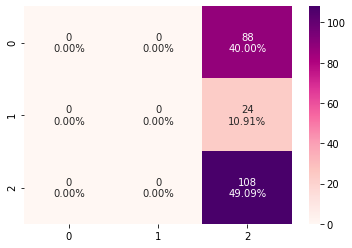

In [119]:
pred_mlpc = model2.predict(X_test)
y_pred_mlpc=np.argmax(pred_mlpc, axis=1)
print(classification_report(y_test, y_pred_mlpc))
#print(confusion_matrix(y_test, pred_mlpc))
print('Neural Network Accuracy: %.3f' % accuracy_score(y_test,y_pred_mlpc))
cm = confusion_matrix(y_test, y_pred_mlpc)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
Labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
Labels = np.asarray(Labels).reshape(3,3)
sns.heatmap(cm, annot=Labels, fmt='', cmap='RdPu')

In [121]:
report = classification_report(y_test, y_pred_mlpc,output_dict=True)
macro_precision =  report['macro avg']['precision'] 
macro_recall = report['macro avg']['recall']    
macro_f1 = report['macro avg']['f1-score']
accuracy = report['accuracy']
listend = []
listend.append(macro_precision)
listend.append(macro_recall)
listend.append(macro_f1)
listend.append(accuracy)
data4['Hybrid Approach'] = listend
data4


C:\Users\Farhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Farhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Farhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,KNN,Decision Tree Classifier,Random Forrest Classifier,Hybrid Approach
Precision,0.996255,0.950613,0.992593,0.163636
Recall,0.986111,0.945707,0.972222,0.333333
F1-Score,0.991025,0.947527,0.981762,0.219512
Accuracy,0.995455,0.959091,0.990909,0.490909
